# Topic Modeling with Gensim

- Wie können wir rausfinden um welche Themen sich die Texte drehen?
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- TODO https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## Modelle runterladen

In [1]:
# Download stopwords nltk
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/plotti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Download spacy model
# !python2.7 -m spacy download en

## Pakete installieren

- ```pip3 install --user gensim```
- ```pip3 install --user pyLDAvis```

# Pakete importieren

In [23]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

#Data 
import requests
from bs4 import BeautifulSoup

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
spacy.load('en')

# LDA

- LDA (Latent Dirichlitet Allocation) sieht jedes Dokument als eine Sammlung von Themen
- Jedes Thema wiederrum ist eine sammlung von Wörtern
- Sobald man als Nutzer die Anzahl der Topics festgelegt hat versucht der Algorithmus die Topics so auf die Dokumente zu verteilen, dass es möglichst optimal ist. 
- Ein Thema ist also nur eine Sammlung von "dominanten" Wörtern für das Thema
- Als Mensch muss man dann dem Kind noch einen Namen geben

Das Endresultat hängt von folgenden Faktoren ab:
    - Die Qualität des Preprocessing 
    - Die Vielfalt der Themen die die Texte behandeln
    - Die Wahl des Topic modeling algorithmus
    - Die Anzahl der Topics die wir haben möchten
    - Den tuning Parametern

# Daten importieren
- Wir holen uns die Daten von der Frontpage von Swissinfo

In [4]:
url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44571990"
tmp = requests.get(url)

In [5]:
soup = BeautifulSoup(tmp.json()["htmldetail"], "lxml")


In [6]:
import requests

items = []
raw_data = []
for i in range(1,10):
    start = (i-1)*100
    end =  i*100
    print("start %s end %s" %(start,end))
    url = "https://www.swissinfo.ch/eng/%s/%s?view=loadMore&end=%s&begin=%s" % (start,end,end,start)
    print(url)
    results = requests.get(url)
    page_content = BeautifulSoup(results.content, "html.parser")
    for link in page_content.select("h3 a"):
        id = link["href"].split("/")[-1]
        url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=%s" % id
        print("--%s" % url)
        tmp = requests.get(url)
        detail_url = "https://www.swissinfo.ch%s" % tmp.json()["item"]["url"]
        print("--%s" % detail_url)
        r = requests.get(detail_url).json()
        try:
            tag = r["header"]["subjectTags"][0]["title"]
        except:
            tag = ""
        soup = BeautifulSoup(r["htmldetail"], "lxml")
        text = " ".join([text.get_text() for text in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', "p"])])
        try:
            url = r["header"]["canonical"]
        except:
            url = ""
        raw_data.append(r)
        items.append({"id": id, "url": url, "tag": tag, "text": text})

start 0 end 100
https://www.swissinfo.ch/eng/0/100?view=loadMore&end=100&begin=0
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44656496
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44656496
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44657906
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44657906
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44658116
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44658116
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44661252
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44661252
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44660092
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44660092
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44658522
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44658522
-

--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44616080
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44616080
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44617654
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44617654
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44617816
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44617816
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44615866
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44615866
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44615656
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44615656
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44613728
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44613728
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44616450
--ht

In [7]:
items[0]

{'id': u'44656496',
 'tag': u'Politics',
 'text': u'Metal poles mark the size of a future building project\xa0in\xa0Uitikon, canton\xa0Zurich As urban development continues apace, should a freeze be placed on the creation of new construction zones? Such is the proposal of a popular initiative put forward by the youth chapter of the Green Party to be voted on by the Swiss on February 10.\xa0 For opponents, the initiative is too radical, and the recently revised Planning Act is more than adequate to reasonably manage urban development. Is Switzerland covered with too much concrete and asphalt? Officially, 7.5% of the country is covered by buildings, roads or other human-built infrastructure. But the figures, which date to 2009 and are the most recent available, do not tell the entire story. Even though each year a surface area equal to the size of Basel disappears underneath concrete, Switzerland is not comparable to countries like the Netherlands or Belgium, where 37% and 25% of the sur

In [8]:
df = pd.DataFrame(items)
df.head()

,id,tag,text,url
0,44656496,Politics,Metal poles mark the size of a future building...,https://www.swissinfo.ch/eng/politics/february...
1,44657906,Society,"Eva Hefti at Smugglers Bay, which is only reac...",https://www.swissinfo.ch/eng/society/-weareswi...
2,44658116,Politics,Here are some of the stories we’ll bring you t...,https://www.swissinfo.ch/eng/society/the-week-...
3,44661252,Business,US prosecutors appear to accept the former CS ...,https://www.swissinfo.ch/eng/business/arrests-...
4,44660092,,Revillard's idiosyncratic use of the flash sho...,https://www.swissinfo.ch/eng/obituary_swiss-ph...


# Bereinigen

In [9]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent).encode('utf-8') for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1][0].split(" ")[0:50])


['Metal', 'poles', 'mark', 'the', 'size', 'of', 'a', 'future', 'building', 'project\xc2\xa0in\xc2\xa0Uitikon,', 'canton\xc2\xa0Zurich', 'As', 'urban', 'development', 'continues', 'apace,', 'should', 'a', 'freeze', 'be', 'placed', 'on', 'the', 'creation', 'of', 'new', 'construction', 'zones?', 'Such', 'is', 'the', 'proposal', 'of', 'a', 'popular', 'initiative', 'put', 'forward', 'by', 'the', 'youth', 'chapter', 'of', 'the', 'Green', 'Party', 'to', 'be', 'voted', 'on']


## Tokenization und weiteres pre-processing

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])[0][0:20]

[u'metal', u'poles', u'mark', u'the', u'size', u'of', u'future', u'building', u'project', u'in', u'uitikon', u'canton', u'zurich', u'as', u'urban', u'development', u'continues', u'apace', u'should', u'freeze']


# Bigrams  und Trigrams erstellen

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/plotti/Library/Python/2.7/lib/python/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[u'metal', u'poles', u'mark', u'the', u'size', u'of', u'future', u'building', u'project', u'in', u'uitikon', u'canton_zurich', u'as', u'urban', u'development', u'continues', u'apace', u'should', u'freeze', u'be_placed', u'on', u'the', u'creation_of', u'new', u'construction', u'zones', u'such', u'is', u'the', u'proposal', u'of', u'popular', u'initiative', u'put_forward', u'by', u'the', u'youth', u'chapter', u'of', u'the', u'green_party', u'to', u'be_voted', u'on', u'by', u'the', u'swiss', u'on', u'february', u'for', u'opponents', u'the', u'initiative', u'is', u'too', u'radical', u'and', u'the', u'recently', u'revised', u'planning_act', u'is', u'more_than', u'adequate', u'to', u'reasonably', u'manage', u'urban', u'development', u'is', u'switzerland', u'covered', u'with', u'too_much', u'concrete', u'and', u'asphalt', u'officially', u'of', u'the', u'country', u'is', u'covered_by', u'buildings', u'roads', u'or', u'other', u'human', u'built', u'infrastructure', u'but', u'the', u'figures', u'

## Stopwörter entfernen, POS Filtering und Lemmatization

In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Custom Stopwords
stop_words.extend(['swiss', "switzerland", "swi", 'fintech', 'array', 'click', 'head', 'html', 'email', 'css', 'society', 'array', 'jquery', 'keystone', 'mailchimp'])

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[[u'metal', u'pole', u'mark', u'size', u'future', u'building', u'project', u'uitikon', u'canton_zurich', u'urban', u'development', u'continue', u'apace', u'freeze', u'placed', u'creation', u'new', u'construction', u'zone', u'proposal', u'popular', u'initiative', u'put_forward', u'youth', u'chapter', u'green_party', u'vote', u'february', u'opponent', u'initiative', u'radical', u'recently', u'revise', u'planning_act', u'adequate', u'reasonably', u'manage', u'urban', u'development', u'cover', u'much', u'concrete', u'asphalt', u'officially', u'country', u'cover', u'building', u'road', u'human', u'build', u'infrastructure', u'figure', u'date', u'recent', u'available', u'tell', u'entire', u'story', u'even_though', u'year', u'surface_area', u'equal', u'size', u'basel', u'disappear', u'concrete', u'comparable', u'country', u'netherland', u'belgium', u'surface_area', u'respectively', u'occupy', u'building', u'railway', u'road', u'neighbouring_countrie', u'also', u'great', u'proportion', u'urban

# Create Dictionairy for LDA
- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

- For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

- This is used as the input by the LDA model.

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 2), (9, 2), (10, 4), (11, 4), (12, 1), (13, 1), (14, 5), (15, 3), (16, 2), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 6), (32, 8), (33, 2), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 2), (54, 2), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 10), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 5), (70, 4), (71, 2), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 5), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 1

- Inverse lookup:

In [16]:
id2word[0]

u'aargau'

In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'aargau', 1),
  (u'abstain', 1),
  (u'accord', 1),
  (u'account', 1),
  (u'activity', 1),
  (u'adequate', 1),
  (u'agree', 2),
  (u'agriculture', 1),
  (u'aim', 2),
  (u'almost', 2),
  (u'already', 4),
  (u'also', 4),
  (u'answer', 1),
  (u'apace', 1),
  (u'area', 5),
  (u'argue', 3),
  (u'argument', 2),
  (u'arosa', 1),
  (u'asphalt', 1),
  (u'association', 2),
  (u'author', 1),
  (u'available', 1),
  (u'average', 2),
  (u'basel', 1),
  (u'belgium', 3),
  (u'benefit', 1),
  (u'bite', 1),
  (u'bituman', 1),
  (u'black', 1),
  (u'break', 1),
  (u'brownfield', 1),
  (u'build', 6),
  (u'building', 8),
  (u'call', 2),
  (u'can', 1),
  (u'canton', 2),
  (u'canton_zurich', 1),
  (u'capital', 1),
  (u'car', 1),
  (u'cemeteri', 1),
  (u'central', 1),
  (u'centre_right', 2),
  (u'champion', 1),
  (u'chancellery', 1),
  (u'chapter', 1),
  (u'christian_democratic', 1),
  (u'city', 1),
  (u'class', 1),
  (u'clear', 1),
  (u'close', 1),
  (u'cloth', 1),
  (u'coming_year', 1),
  (u'committee', 2

# Build LDA Model

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View LDA Model

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  u'0.011*"say" + 0.006*"company" + 0.006*"see" + 0.005*"bank" + 0.005*"get" + 0.005*"also" + 0.004*"make" + 0.004*"would" + 0.004*"take" + 0.004*"business"'),
 (1,
  u'0.005*"also" + 0.005*"year" + 0.005*"say" + 0.004*"get" + 0.004*"swissinfo_ch" + 0.004*"see" + 0.004*"new" + 0.003*"country" + 0.003*"federal_council" + 0.003*"time"'),
 (2,
  u'0.005*"system" + 0.005*"new" + 0.005*"also" + 0.005*"say" + 0.005*"see" + 0.004*"work" + 0.004*"go" + 0.004*"party" + 0.004*"swissinfo_ch" + 0.003*"day"'),
 (3,
  u'0.008*"research" + 0.007*"also" + 0.005*"project" + 0.005*"use" + 0.005*"swissinfo_ch" + 0.005*"darpa" + 0.005*"science" + 0.005*"work" + 0.004*"addiction" + 0.004*"say"'),
 (4,
  u'0.009*"say" + 0.006*"country" + 0.005*"also" + 0.005*"would" + 0.004*"glencore" + 0.004*"get" + 0.004*"dog" + 0.004*"government" + 0.004*"come" + 0.003*"law"'),
 (5,
  u'0.008*"country" + 0.006*"say" + 0.006*"migration" + 0.004*"would" + 0.004*"tax" + 0.004*"see" + 0.004*"accord" + 0.004*"state" + 0.

# How good is the model?

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -8.194456019226251)
('\nCoherence Score: ', 0.24795248366586606)


- Everything below a coherence score of 0.3 is quite bad

# Visualize topic keywords
- Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
- A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
- If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/plotti/Library/Python/2.7/lib/python/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      23.431503        1       1 -0.018204  0.019027
4      19.569784        1       2 -0.052549 -0.004069
0      17.778822        1       3 -0.035386  0.029263
5      17.505758        1       4  0.011471 -0.130051
2      14.659958        1       5 -0.053797  0.049851
3       7.054167        1       6  0.148465  0.035979, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
1002  Default   28.000000       research   28.000000  30.0000  30.0000
1091  Default   44.000000      migration   44.000000  29.0000  29.0000
3687  Default   32.000000       glencore   32.000000  28.0000  28.0000
187   Default   53.000000        project   53.000000  27.0000  27.0000
937   Default   28.000000        science   28.000000  26.0000  26.0000
1860  Default   48.000000           bank   48.000000  25.0000  25.0000
3556  Default   29.000000            dog   29.000000  24.0000  24.0000
2687  Default   21.000000          syria   21.000000  23.0000  23.0000
1541  Default   12.000000          darpa   12.000000  22.0000  22.0000
6338  Default   60.000000            use   60.000000  21.0000  21.0000
2699  Default   24.000000        station   24.000000  20.0000  20.0000
4715  Default   11.000000      addiction   11.000000  19.0000  19.0000
2065  Default   12.000000           epfl   12.000000  18.0000  18.0000
4205  Default   23.000000           film   23.000000  17.0000  17.0000
6288  Default  100.000000   swissinfo_ch  100.000000  16.0000  16.0000
1016  Default   37.000000         number   37.000000  15.0000  15.0000
2090  Default   18.000000            war   18.000000  14.0000  14.0000
929   Default   91.000000        company   91.000000  13.0000  13.0000
1463  Default   59.000000         system   59.000000  12.0000  12.0000
6455  Default   20.000000          yodel   20.000000  11.0000  11.0000
5163  Default   14.000000     researcher   14.000000  10.0000  10.0000
6361  Default   37.000000            tax   37.000000   9.0000   9.0000
5814  Default   15.000000         racism   15.000000   8.0000   8.0000
3009  Default   13.000000      chevrolet   13.000000   7.0000   7.0000
5209  Default   22.000000         client   22.000000   6.0000   6.0000
1555  Default   24.000000        migrant   24.000000   5.0000   5.0000
605   Default   12.000000       internet   12.000000   4.0000   4.0000
1045  Default  163.000000           also  163.000000   3.0000   3.0000
275   Default  140.000000        country  140.000000   2.0000   2.0000
4660  Default   27.000000       exchange   27.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
6471   Topic6    3.509089  collaboration    5.067863   2.2840  -6.5375
1689   Topic6    3.525269     venezuelan    5.095577   2.2831  -6.5329
4197   Topic6    3.079361       citation    4.355670   2.3048  -6.6681
3241   Topic6    6.233688          drone   10.368405   2.1428  -5.9629
5163   Topic6    8.000236     researcher   14.305422   2.0704  -5.7134
3282   Topic6    4.634375        journal    7.366676   2.1881  -6.2594
605    Topic6    6.923744       internet   12.948834   2.0255  -5.8579
937    Topic6   11.594719        science   28.898491   1.7383  -5.3423
4920   Topic6    4.876493         clinic    9.005995   2.0381  -6.2084
187    Topic6   13.031714        project   53.163464   1.2456  -5.2255
6338   Topic6   12.925006            use   60.913021   1.1013  -5.2337
1016   Topic6    9.347522         number   37.585342   1.2600  -5.5578
816    Topic6    5.844956     scientific   16.557205   1.6103  -6.0273
6288   Topic6   12.882833   swissinfo_ch  100.206757   0.6002  -5.2370
1045   Topic6   15.852697           also  163.320328   0.3192  -5.0295
1797   Topic6   10.914010           work   97.359825   0.4632  -5.4028
745    Topic6    6.963541         former   30.

# Improve with LDA Mallet model

In [26]:
mallet_path = '/Users/plotti/code/text/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [27]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [(u'law', 0.02791563275434243),
   (u'exchange', 0.019851116625310174),
   (u'trading', 0.017990074441687345),
   (u'blockchain', 0.017369727047146403),
   (u'form', 0.013027295285359801),
   (u'security', 0.01240694789081886),
   (u'financial', 0.011166253101736972),
   (u'act', 0.01054590570719603),
   (u'platform', 0.01054590570719603),
   (u'change', 0.01054590570719603)]),
 (9,
  [(u'good', 0.03800967519004837),
   (u'project', 0.036627505183137524),
   (u'work', 0.03248099516240498),
   (u'university', 0.029716655148583276),
   (u'research', 0.02626123013130615),
   (u'important', 0.021423635107118175),
   (u'explain', 0.018659295093296474),
   (u'focus', 0.013130615065653075),
   (u'researcher', 0.01243953006219765),
   (u'epfl', 0.011748445058742226)]),
 (10,
  [(u'migration', 0.026355803345159655),
   (u'country', 0.02280790674100355),
   (u'human_right', 0.01824632539280284),
   (u'support', 0.01419158641662443),
   (u'migrant', 0.01419158641662443),
   (u'internation

In [30]:
pyLDAvis.enable_notebook()
lda_model_2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
10     6.883529        1       1  0.000247  0.000363
17     6.607788        1       2 -0.000130 -0.000015
14     6.465064        1       3 -0.000562  0.000110
11     5.875163        1       4 -0.000605 -0.000207
15     5.532647        1       5  0.000423 -0.001075
8      5.491060        1       6 -0.000286  0.000548
5      5.160827        1       7  0.000392 -0.000217
12     5.078035        1       8  0.000670 -0.000482
1      4.991784        1       9  0.000054  0.000253
16     4.963386        1      10 -0.000001  0.000197
9      4.838257        1      11 -0.000208 -0.000385
19     4.686263        1      12 -0.000100 -0.000053
13     4.676419        1      13  0.000291  0.000183
6      4.640871        1      14 -0.000277 -0.000210
7      4.637025        1      15 -0.000707 -0.000471
4      4.631377        1      16  0.000118  0.000374
3      3.837440        1      17  0.000033  0.000285
0      3.784686        1      18 -0.000220  0.000066
18     3.628351        1      19  0.000058  0.000415
2      3.590028        1      20  0.000810  0.000320, topic_info=     Category      Freq                Term     Total  loglift  logprob
term                                                                   
5429  Default  5.000000          well_known  5.000000  30.0000  30.0000
4836  Default  5.000000                beam  5.000000  29.0000  29.0000
822   Default  5.000000               stone  5.000000  28.0000  28.0000
414   Default  5.000000              lgbtiq  5.000000  27.0000  27.0000
117   Default  5.000000          democratic  5.000000  26.0000  26.0000
840   Default  5.000000            complete  5.000000  25.0000  25.0000
5538  Default  5.000000             graggen  5.000000  24.0000  24.0000
5763  Default  5.000000         extradition  5.000000  23.0000  23.0000
5564  Default  5.000000    migration_driver  5.000000  22.0000  22.0000
5212  Default  5.000000              rumble  5.000000  21.0000  21.0000
1302  Default  5.000000              garden  5.000000  20.0000  20.0000
2487  Default  5.000000           proponent  5.000000  19.0000  19.0000
4948  Default  5.000000          journalist  5.000000  18.0000  18.0000
6018  Default  5.000000           misreport  5.000000  17.0000  17.0000
5993  Default  5.000000             top_ten  5.000000  16.0000  16.0000
5425  Default  5.000000           radically  5.000000  15.0000  15.0000
6194  Default  5.000000               cheer  5.000000  14.0000  14.0000
4255  Default  5.000000              burger  5.000000  13.0000  13.0000
2735  Default  5.000000               eaten  5.000000  12.0000  12.0000
1604  Default  4.000000           indonesia  4.000000  11.0000  11.0000
4893  Default  5.000000               defie  5.000000  10.0000  10.0000
4415  Default  5.000000         significant  5.000000   9.0000   9.0000
5563  Default  5.000000        individually  5.000000   8.0000   8.0000
4519  Default  5.000000              moment  5.000000   7.0000   7.0000
4116  Default  5.000000              assist  5.000000   6.0000   6.0000
2623  Default  5.000000              phrase  5.000000   5.0000   5.0000
4594  Default  5.000000         immigration  5.000000   4.0000   4.0000
5392  Default  5.000000                rely  5.000000   3.0000   3.0000
5353  Default  5.000000            jennifer  5.000000   2.0000   2.0000
2377  Default  4.000000  democracy_building  4.000000   1.0000   1.0000
...       ...       ...                 ...       ...      ...      ...
2707  Topic20  0.240771             boredom  5.158131   0.2625  -8.5413
5315  Topic20  0.238377              portal  5.125924   0.2588  -8.5513
5289  Topic20  0.243901                beef  5.244901   0.2588  -8.5284
1772  Topic20  0.233521              michal  5.025030   0.2581  -8.5719
5675  Topic20  0.239837          importance  5.163326   0.2576  -8.5452
3307  Topic20  0.241311               north  5.199969  

# Compute the optimal number of topics

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Working on %s" % (num_topics))
        #model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [32]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

Working on 2
Working on 5
Working on 8
Working on 11
Working on 14
Working on 17
Working on 20
Working on 23
Working on 26
Working on 29
Working on 32
Working on 35
Working on 38


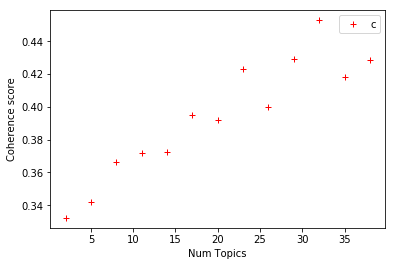

In [33]:
# Show graph
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values,'r+')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

('Num Topics =', 2, ' has Coherence Value of', 0.3323)
('Num Topics =', 5, ' has Coherence Value of', 0.3419)
('Num Topics =', 8, ' has Coherence Value of', 0.3661)
('Num Topics =', 11, ' has Coherence Value of', 0.372)
('Num Topics =', 14, ' has Coherence Value of', 0.3725)
('Num Topics =', 17, ' has Coherence Value of', 0.3949)
('Num Topics =', 20, ' has Coherence Value of', 0.3918)
('Num Topics =', 23, ' has Coherence Value of', 0.4228)
('Num Topics =', 26, ' has Coherence Value of', 0.4001)
('Num Topics =', 29, ' has Coherence Value of', 0.429)
('Num Topics =', 32, ' has Coherence Value of', 0.4528)
('Num Topics =', 35, ' has Coherence Value of', 0.4184)
('Num Topics =', 38, ' has Coherence Value of', 0.4283)


- Lets pick a model that has a high value before it starts flattening out. 

In [35]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(0,
  u'0.023*"bank" + 0.018*"service" + 0.018*"exchange" + 0.016*"start" + 0.016*"blockchain"'),
 (1,
  u'0.038*"work" + 0.022*"company" + 0.019*"good" + 0.018*"world" + 0.017*"job"'),
 (2,
  u'0.042*"country" + 0.030*"migration" + 0.017*"project" + 0.017*"people" + 0.017*"region"'),
 (3,
  u'0.022*"top_storie" + 0.018*"deal" + 0.015*"deliver" + 0.015*"sign" + 0.014*"trade"'),
 (4,
  u'0.036*"time" + 0.022*"dog" + 0.018*"part" + 0.017*"experience" + 0.016*"people"'),
 (5,
  u'0.024*"science" + 0.018*"film" + 0.018*"good" + 0.016*"focus" + 0.014*"scientific"'),
 (6,
  u'0.019*"global" + 0.017*"company" + 0.015*"challenge" + 0.015*"woman" + 0.014*"include"'),
 (7,
  u'0.021*"inbox" + 0.019*"station" + 0.018*"large" + 0.017*"car" + 0.017*"day"'),
 (8,
  u'0.019*"case" + 0.017*"geneva" + 0.015*"syria" + 0.014*"state" + 0.014*"authority"'),
 (9,
  u'0.040*"swissinfo_ch" + 0.026*"free_newsletter" + 0.024*"sign" + 0.023*"family" + 0.022*"inbox"'),
 (10,
  u'0.027*"system" + 0.023*"citizen" 

In [36]:
pyLDAvis.enable_notebook()
lda_model_2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics             x         y
topic                                                   
6      7.345450        1       1  2.982958e-04 -0.000266
3      7.061532        1       2  2.811418e-04  0.000194
14     6.995949        1       3  6.661517e-04  0.000485
11     6.948070        1       4 -4.300269e-04 -0.001122
10     6.802013        1       5 -4.962064e-04 -0.000158
13     6.508041        1       6 -7.188126e-07  0.000033
0      6.168870        1       7 -6.340834e-04  0.000403
15     5.893998        1       8 -5.245567e-04  0.000128
2      5.775113        1       9 -1.284464e-04  0.000335
8      5.564680        1      10 -1.515916e-04  0.000191
16     5.383984        1      11  2.385388e-04 -0.000363
9      5.325610        1      12 -2.694021e-04 -0.000247
1      5.154321        1      13  3.012199e-04  0.000375
4      5.112314        1      14  7.179899e-04 -0.000580
5      4.995846        1      15  1.414474e-04  0.000164
7      4.577744        1      16  4.445285e-04  0.000032
12     4.386465        1      17 -4.542816e-04  0.000394, topic_info=     Category      Freq              Term     Total  loglift  logprob
term                                                                 
817   Default  5.000000             power  5.000000  30.0000  30.0000
4458  Default  5.000000        bus_driver  5.000000  29.0000  29.0000
1779  Default  5.000000             smoke  5.000000  28.0000  28.0000
251   Default  5.000000        peripheral  5.000000  27.0000  27.0000
1509  Default  5.000000            decade  5.000000  26.0000  26.0000
6009  Default  5.000000            lamine  5.000000  25.0000  25.0000
6550  Default  5.000000           present  5.000000  24.0000  24.0000
3329  Default  5.000000        ideational  5.000000  23.0000  23.0000
5853  Default  5.000000            symbol  5.000000  22.0000  22.0000
572   Default  4.000000   internationally  4.000000  21.0000  21.0000
4370  Default  4.000000      circumstance  4.000000  20.0000  20.0000
4761  Default  5.000000       interaction  5.000000  19.0000  19.0000
393   Default  5.000000        infraction  5.000000  18.0000  18.0000
2984  Default  5.000000       culmination  5.000000  17.0000  17.0000
288   Default  5.000000        extraction  5.000000  16.0000  16.0000
3406  Default  5.000000         lucrative  5.000000  15.0000  15.0000
5345  Default  5.000000  francois_schwalb  5.000000  14.0000  14.0000
4829  Default  5.000000           bernard  5.000000  13.0000  13.0000
5493  Default  5.000000           bribery  5.000000  12.0000  12.0000
2498  Default  5.000000          assembly  5.000000  11.0000  11.0000
4934  Default  5.000000               ado  5.000000  10.0000  10.0000
4245  Default  4.000000        difference  4.000000   9.0000   9.0000
2403  Default  4.000000              mont  4.000000   8.0000   8.0000
6299  Default  5.000000             trift  5.000000   7.0000   7.0000
2825  Default  5.000000         makeshift  5.000000   6.0000   6.0000
2893  Default  5.000000             block  5.000000   5.0000   5.0000
3873  Default  5.000000              purr  5.000000   4.0000   4.0000
5867  Default  4.000000            follow  4.000000   3.0000   3.0000
5155  Default  5.000000      independence  5.000000   2.0000   2.0000
2618  Default  5.000000              nino  5.000000   1.0000   1.0000
...       ...       ...               ...       ...      ...      ...
4775  Topic17  0.287433          anzeiger  4.977997   0.2749  -8.5645
4802  Topic17  0.294107           gravita  5.107037   0.2722  -8.5416
5135  Topic17  0.291570          hitherto  5.117445   0.2615  -8.5502
917   Topic17  0.276290            social  4.866582   0.2579  -8.6041
1412  Topic17  0.285139             hobby  5.037308   0.2550  -8.5725
572   Topic17  0.277209   internationally  4.902990   0.2538  -8.6008
2140  Topic17  0.284392            battle  5.036494   0.2525  -8.5752
1381  Topic17  0.296299      french_speak  5.259199   0.2503  -8.5342
581 

# Getting the most dominant topic for each Text

In [38]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.4561,"year, initiative, canton, end, tax, vote, reje...",Metal poles mark the size of a future building...
1,1,9.0,0.3456,"swissinfo_ch, free_newsletter, sign, family, w...","Eva Hefti at Smugglers Bay, which is only reac..."
2,2,3.0,0.1547,"top_storie, deal, deliver, sign, trade, inbox,...",Here are some of the stories we’ll bring you t...
3,3,15.0,0.5386,"glencore, company, face, make, group, investor...",US prosecutors appear to accept the former CS ...
4,4,1.0,0.4127,"work, company, good, world, job, big, student,...",Revillards idiosyncratic use of the flash shon...
5,5,3.0,0.2091,"top_storie, deal, deliver, sign, trade, inbox,...",Almost every article published by swissinfo.ch...
6,6,9.0,0.1068,"swissinfo_ch, free_newsletter, sign, family, w...","In this series, swissinfo.ch picture editors c..."
7,7,13.0,0.3027,"climate, year, climate_change, alpine, rise, a...",Werner Freitag and his team are out every nigh...
8,8,8.0,0.4980,"case, geneva, syria, authority, state, private...",Cameroons president Paul Biya and his wife Cha...
9,9,11.0,0.3624,"year, initiative, canton, end, tax, vote, reje...",Artist Peter Baracchi came up with the idea fo...


# Find the most relevant document per topic

In [39]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6280,"bank, service, exchange, start, blockchain, la...",Blockchain and crypto tokens have the potentia...
1,1.0,0.5677,"work, company, good, world, job, big, student,...",More than 90% of students in the last three gr...
2,2.0,0.5988,"country, migration, project, people, region, e...",Protests against government cuts in Tunisia: p...
3,3.0,0.6312,"top_storie, deal, deliver, sign, trade, inbox,...",The US Ambassador to Switzerland says there is...
4,4.0,0.5909,"time, dog, part, experience, people, small, da...","The Saint Bernard, featured in everything fro..."
5,5.0,0.6132,"science, film, good, focus, public, scientific...",Brainstorming: Participants must figure out ho...
6,6.0,0.5591,"global, company, challenge, woman, include, co...",Commodity trading accounts for nearly 4% of Sw...
7,7.0,0.5718,"inbox, station, large, car, day, long, run, ma...",Switzerland is known worldwide for its very de...
8,8.0,0.4980,"case, geneva, syria, authority, state, private...",Cameroons president Paul Biya and his wife Cha...
9,9.0,0.5395,"swissinfo_ch, free_newsletter, sign, family, w...","A post shared by SWI swissinfo.ch on Aug 29, 2..."


# How are the topics distributed across all of our documents

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = topic_counts/topic_counts.sum()

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"bank, service, exchange, start, blockchain, la...",3,0.030928
1,1.0,"work, company, good, world, job, big, student,...",5,0.051546
2,2.0,"country, migration, project, people, region, e...",3,0.030928
3,3.0,"top_storie, deal, deliver, sign, trade, inbox,...",13,0.134021
4,4.0,"time, dog, part, experience, people, small, da...",3,0.030928
5,5.0,"science, film, good, focus, public, scientific...",2,0.020619
6,6.0,"global, company, challenge, woman, include, co...",5,0.051546
7,7.0,"inbox, station, large, car, day, long, run, ma...",6,0.061856
8,8.0,"case, geneva, syria, authority, state, private...",5,0.051546
9,9.0,"swissinfo_ch, free_newsletter, sign, family, w...",11,0.113402


# Words per Document

In [41]:
doc_lenghts = [len(list(sent_to_words(d))) for d in df_dominant_topic.Text]
len(doc_lenghts)

97

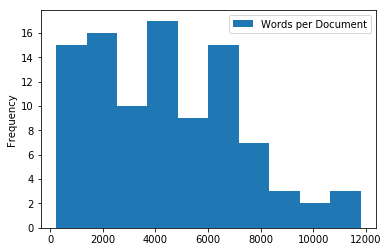

In [42]:
pd.DataFrame(doc_lenghts,columns=["Words per Document"]).plot(kind="hist")

# Distribution by Topic

In [43]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.4561,"year, initiative, canton, end, tax, vote, reje...",Metal poles mark the size of a future building...
1,1,9.0,0.3456,"swissinfo_ch, free_newsletter, sign, family, w...","Eva Hefti at Smugglers Bay, which is only reac..."
2,2,3.0,0.1547,"top_storie, deal, deliver, sign, trade, inbox,...",Here are some of the stories we’ll bring you t...
3,3,15.0,0.5386,"glencore, company, face, make, group, investor...",US prosecutors appear to accept the former CS ...
4,4,1.0,0.4127,"work, company, good, world, job, big, student,...",Revillards idiosyncratic use of the flash shon...


In [44]:
df_dominant_topic["Text_Length"] = df_dominant_topic["Text"].str.len()
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Text_Length
0,0,11.0,0.4561,"year, initiative, canton, end, tax, vote, reje...",Metal poles mark the size of a future building...,7131
1,1,9.0,0.3456,"swissinfo_ch, free_newsletter, sign, family, w...","Eva Hefti at Smugglers Bay, which is only reac...",4564
2,2,3.0,0.1547,"top_storie, deal, deliver, sign, trade, inbox,...",Here are some of the stories we’ll bring you t...,1328
3,3,15.0,0.5386,"glencore, company, face, make, group, investor...",US prosecutors appear to accept the former CS ...,4692
4,4,1.0,0.4127,"work, company, good, world, job, big, student,...",Revillards idiosyncratic use of the flash shon...,3186


In [45]:
tmp = df_dominant_topic.groupby(by="Dominant_Topic").agg({'Document_No':['count'], "Text_Length": "mean"}) 
tmp.columns = ["Documents","Average_Length"]
tmp = tmp.reset_index()

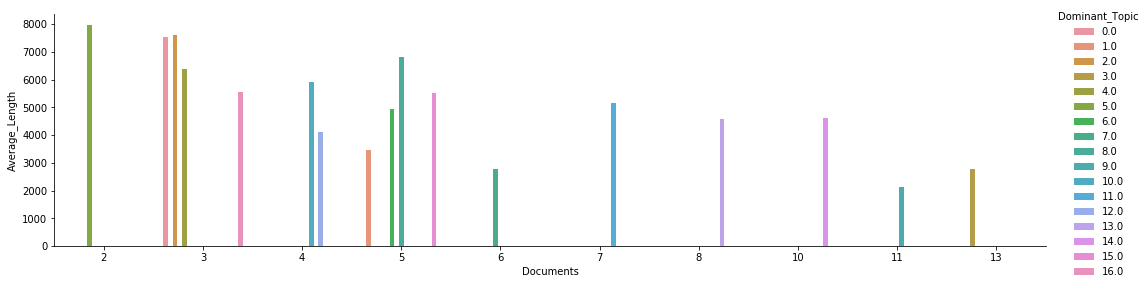

In [46]:
import seaborn as sns
g = sns.catplot(x="Documents", y="Average_Length", hue="Dominant_Topic",data=tmp, kind="bar",height=4, aspect=3.7)